# Vogels_et_al_2011

code source: https://brian2.readthedocs.io/en/stable/examples/frompapers.Vogels_et_al_2011.html

paper: https://www.science.org/doi/10.1126/science.1211095

In [1]:
from brian2 import *

def Vogels2011(integrator):

    # ###########################################
    # Defining network model parameters
    # ###########################################

    NE = 8000 #8000          # Number of excitatory cells
    NI = NE/4          # Number of inhibitory cells

    tau_ampa = 5.0*ms   # Glutamatergic synaptic time constant
    tau_gaba = 10.0*ms  # GABAergic synaptic time constant
    epsilon = 0.02      # Sparseness of synaptic connections

    tau_stdp = 20*ms    # STDP time constant

    simtime = 1*second #10*second # Simulation time

    # ###########################################
    # Neuron model
    # ###########################################

    gl = 10.0*nsiemens   # Leak conductance
    el = -60*mV          # Resting potential
    er = -80*mV          # Inhibitory reversal potential
    vt = -50.*mV         # Spiking threshold
    memc = 200.0*pfarad  # Membrane capacitance
    bgcurrent = 200*pA   # External current

    eqs_neurons='''
    dv/dt=(-gl*(v-el)-(g_ampa*v+g_gaba*(v-er))+bgcurrent)/memc : volt (unless refractory)
    dg_ampa/dt = -g_ampa/tau_ampa : siemens
    dg_gaba/dt = -g_gaba/tau_gaba : siemens
    '''

    # ###########################################
    # Initialize neuron group
    # ###########################################

    neurons = NeuronGroup(NE+NI, model=eqs_neurons, threshold='v > vt',
                          reset='v=el', refractory=5*ms, method=integrator)
    Pe = neurons[:NE]
    Pi = neurons[NE:]

    # ###########################################
    # Connecting the network
    # ###########################################

    con_e = Synapses(Pe, neurons, on_pre='g_ampa += 0.3*nS')
    con_e.connect(p=epsilon)
    con_ii = Synapses(Pi, Pi, on_pre='g_gaba += 3*nS')
    con_ii.connect(p=epsilon)

    # ###########################################
    # Inhibitory Plasticity
    # ###########################################

    eqs_stdp_inhib = '''
    w : 1
    dApre/dt=-Apre/tau_stdp : 1 (event-driven)
    dApost/dt=-Apost/tau_stdp : 1 (event-driven)
    '''
    alpha = 3*Hz*tau_stdp*2  # Target rate parameter
    gmax = 100               # Maximum inhibitory weight

    con_ie = Synapses(Pi, Pe, model=eqs_stdp_inhib,
                      on_pre='''Apre += 1.
                             w = clip(w+(Apost-alpha)*eta, 0, gmax)
                             g_gaba += w*nS''',
                      on_post='''Apost += 1.
                              w = clip(w+Apre*eta, 0, gmax)
                           ''')
    con_ie.connect(p=epsilon)
    con_ie.w = 1e-10

    # ###########################################
    # Setting up monitors
    # ###########################################

    sm = SpikeMonitor(Pe)

    # ###########################################
    # Run without plasticity
    # ###########################################
    eta = 0          # Learning rate
    run(1*second)

    # ###########################################
    # Run with plasticity
    # ###########################################
    eta = 1e-2          # Learning rate
    run(simtime-1*second, report='text')

    # ###########################################
    # Make plots
    # ###########################################

    i, t = sm.it
    subplot(211)
    plot(t/ms, i, 'k.', ms=0.25)
    title("Before")
    xlabel("")
    yticks([])
    xlim(0.8*1e3, 1*1e3)
    subplot(212)
    plot(t/ms, i, 'k.', ms=0.25)
    xlabel("time (ms)")
    yticks([])
    title("After")
    xlim((simtime-0.2*second)/ms, simtime/ms)
    show()
    
    

exponential_euler


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Starting simulation at t=1. s for a duration of 0. s
0. s (100%) simulated in < 1s


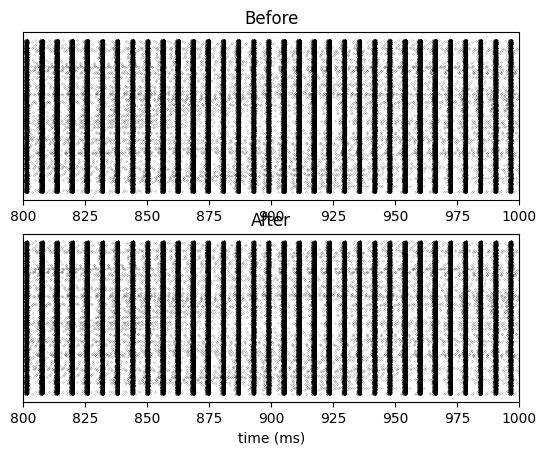

euler
Starting simulation at t=1. s for a duration of 0. s
0. s (100%) simulated in < 1s


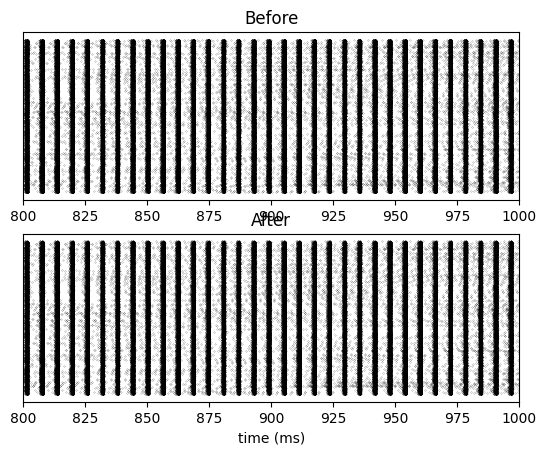

rk2
Starting simulation at t=1. s for a duration of 0. s
0. s (100%) simulated in < 1s


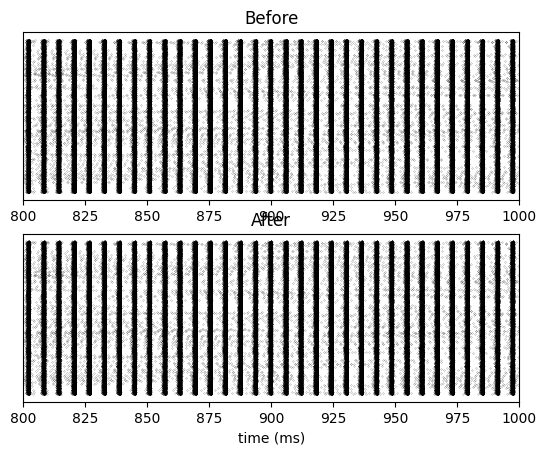

rk4
Starting simulation at t=1. s for a duration of 0. s
0. s (100%) simulated in < 1s


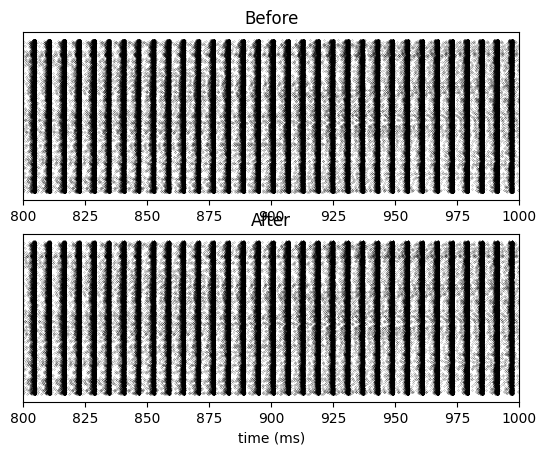

heun
Starting simulation at t=1. s for a duration of 0. s
0. s (100%) simulated in < 1s


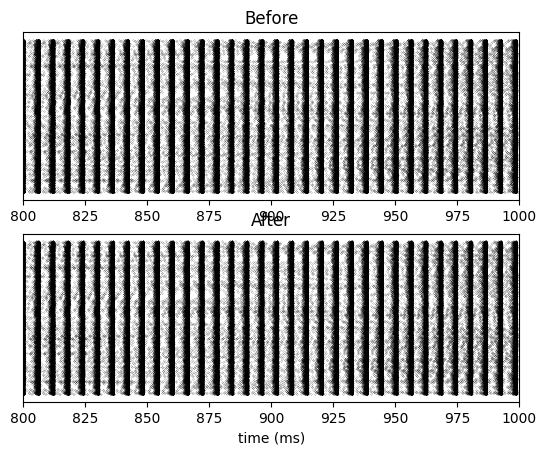

milstein
Starting simulation at t=1. s for a duration of 0. s
0. s (100%) simulated in < 1s


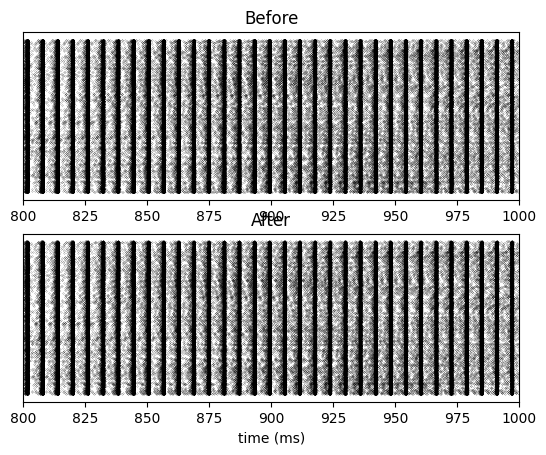

In [2]:
integrators=[#'exact', 
             'exponential_euler', 
             'euler', 
             'rk2', 
             'rk4', 
             'heun', 
             'milstein']

for integrator in integrators:
    print(integrator)
    Vogels2011(integrator)